In [4]:
# 파이썬 라이브러리
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# elem.send_keys(Keys.ENTER)
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import time
from datetime import datetime

import pymysql # mysql 연결및 실행을 위한 모듈
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt #차트 처리를 위한 모듈
%matplotlib inline
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from PIL import *
import seaborn as sns

In [18]:
# 교보문고 연간 베스트셀러 100권(2010-2022 5년간) url 스크래핑

user_agent = 'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.366'

years = [i for i in range(2010,2023)]
urls = []
for year in years: # 2010-2022 5년간 반복
    urls.append([])
    for i in range(1,6): # 한 페이지 당 20권, 5페이지 반복
        # 연간 베스트렐러 목록 페이지 불러오기
        url = 'https://product.kyobobook.co.kr/bestseller/total?period=004#?page=%d&per=20&period=004&ymw=%d&bsslBksClstCode=A'%(i,year)

        options = webdriver.ChromeOptions()
        options.add_argument(user_agent)
        options.add_argument('headless') # 페이지 안 열기
        options.add_argument('window-size=1920x1080')
        options.add_argument("disable-gpu")
        # 혹은 options.add_argument("--disable-gpu")
        driver = webdriver.Chrome(options=options)
        # driver.maximize_window()
        driver.implicitly_wait(2)
        driver.get(url)
        time.sleep(1)

        # 각 책의 url 뽑아 urls list에 저장
        elems = driver.find_elements_by_class_name('prod_link')
        for j in range(len(elems)):
            urls[-1].append(elems[j].get_attribute('href'))
    print(year)

# year_urls 딕셔너리, 키는 연도, 값은 연간베스트도서 url 100개짜리 리스트
year_urls = dict(zip(years,urls))


In [ ]:
# sql 연결 및 best_books_5years 테이블 생성
db = pymysql.connect(host='localhost', port=3306, user='root', passwd='1234', db='mywork', charset='utf8')
cursor = db.cursor()
sql = """
    CREATE TABLE IF NOT EXISTS best_books_12years(
        years SMALLINT NOT NULL,
        ranks SMALLINT NOT NULL,
        title VARCHAR(100),
        author VARCHAR(100),
        publisher VARCHAR(100),
        publishdate DATE,
        price INT,
        rate DOUBLE,
        likes VARCHAR(50),
        review_n INT,
        genre VARCHAR(50),
        page INT);"""
cursor.execute(sql)

In [5]:
# 테이블 채우기
for key, value in year_urls.items():
    # years <- key
    for i in range(len(value)):
        # ranks <- i+1
        
        headers = {'User-Agent':user_agent}
        response = requests.get(value[i], headers) # value[i]가 각 도서링크
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        title = soup.select_one('div.prod_title_area h1').text.replace(' ', '').replace('\n', '')
        # title <- title

        author = soup.select_one('div.author').text.replace(' ', '').replace('\n', '').split('저')
        # author <- author[0]

        publish_info = soup.select_one('div.prod_info_text.publish_date').text
        publish_info = publish_info.replace(' ', '').replace('\n', '').split('·')
        # publisher <- publish_info[0]
        datetime_format = "%Y년%m월%d일"
        publishdate = datetime.strptime(publish_info[1][:11], datetime_format).date()
        # publishdate <- publishdate

        price = soup.select_one('span.price span.val').text.replace('원', '').replace(',', '')
        # price <- price
        
        try:
            rating = soup.select_one('span.review_score.feel_lucky').text
        except:
            rating = 0
        # rate <- rating

        like = soup.select_one('span.review_quotes_text').text
        # likes <- like

        cnt_review = soup.select_one('span.review_desc span.val').text
        # review_n <- cnt_review
        
        genere = soup.select('ol li.breadcrumb_item a')
        # genre <- genere[2].text
        
        page_link = soup.select('tr>td')
        page=page_link[2].text
        page_num = re.sub(r'[^0-9]', '', page)
        if page_num == '':
            page_num = page_num.replace('', '0')
        # page <- int(page_num)    
        
        sql = '''INSERT INTO best_books_12years VALUES(
        {0}, {1}, "{2}", "{3}", "{4}", "{5}", {6}, {7}, "{8}", {9}, "{10}", {11});
        '''.format(key, i+1, title, author[0], publish_info[0], publishdate,
                   int(price), float(rating), like, int(cnt_review), genere[2].text, int(page_num))
        cursor.execute(sql)
        print(key, ', ',i,'done', title)
    
        
db.commit()

NameError: name 'year_urls' is not defined

In [6]:
db = pymysql.connect(host='localhost', port=3306, user='root', passwd='1234', db='mywork', charset='utf8')
cursor = db.cursor()

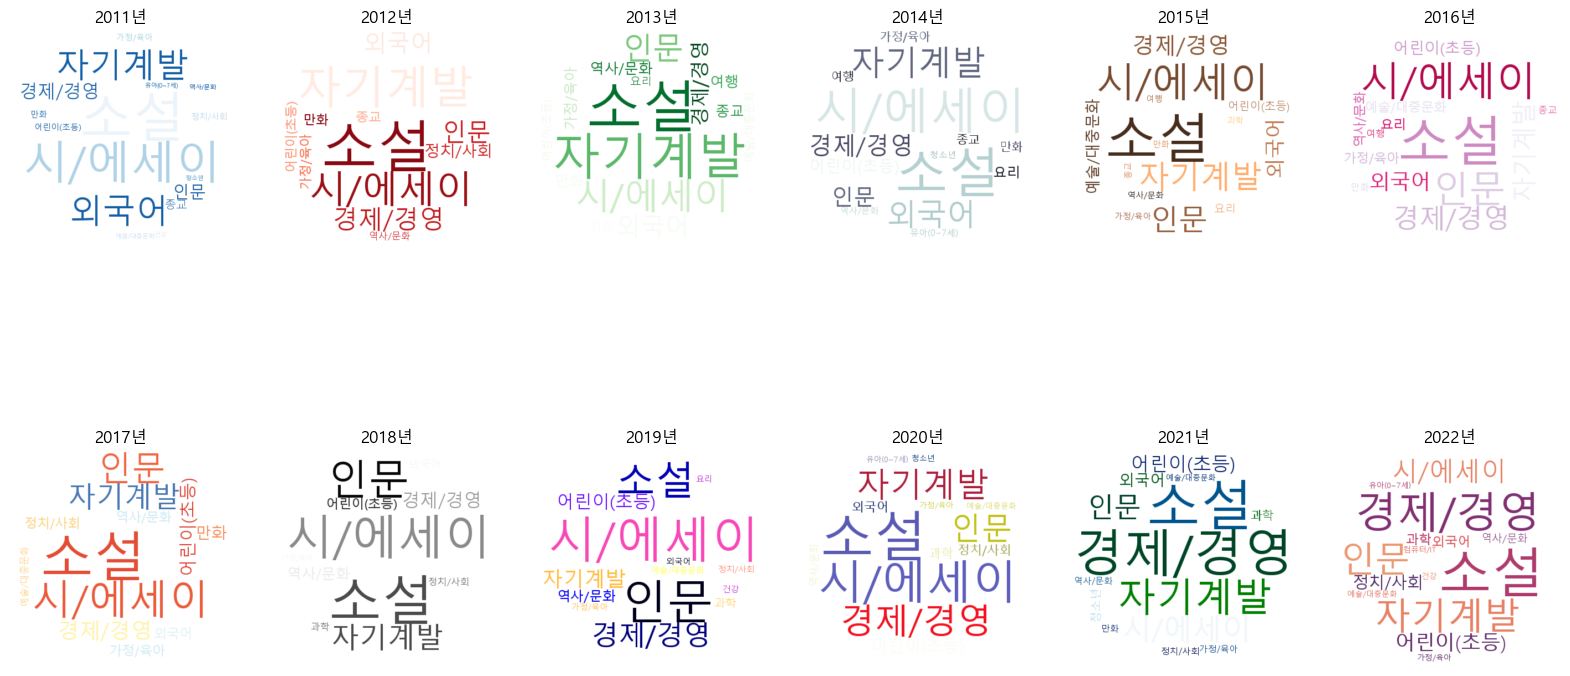

In [11]:
# 워드클라우드 연도별로 출력하기

# 한글 폰트 설정
# print([font.name for font in fm.fontManager.ttflist]) # 설치된 폰트 출력
plt.rcParams['font.family'] = 'Malgun Gothic'

# 워드 클라우드 이미지
cand_mask=np.array(Image.open('circle.jpg')) 

# 2010년부터 2022년까지
plt.figure(figsize=(20,10))
years = [i for i in range(2011,2023)]
colors = ['Blues','Reds','Greens','bone','copper','PuRd','RdYlBu','binary','gnuplot2_r','gist_stern','ocean', 'flare']
i = 1
for year in years:
    SQL = """SELECT genre, count(*)
    FROM best_books_12years
    WHERE years = {}
    GROUP BY genre;""".format(year) #  SQL 구문 만들기
    cursor.execute(SQL)
    res = cursor.fetchall()
    dict_res = dict((x,y)for x,y in res) # tuple -> dictionary
    # wrodcloud 생성
    wordcloud = WordCloud(font_path='malgun.ttf', background_color='white', 
                          colormap=colors[i-1], mask=cand_mask,).generate_from_frequencies(dict_res)
    plt.subplot(2,6,i)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title('{}년'.format(year))
    plt.axis('off')
    i+=1
plt.show()

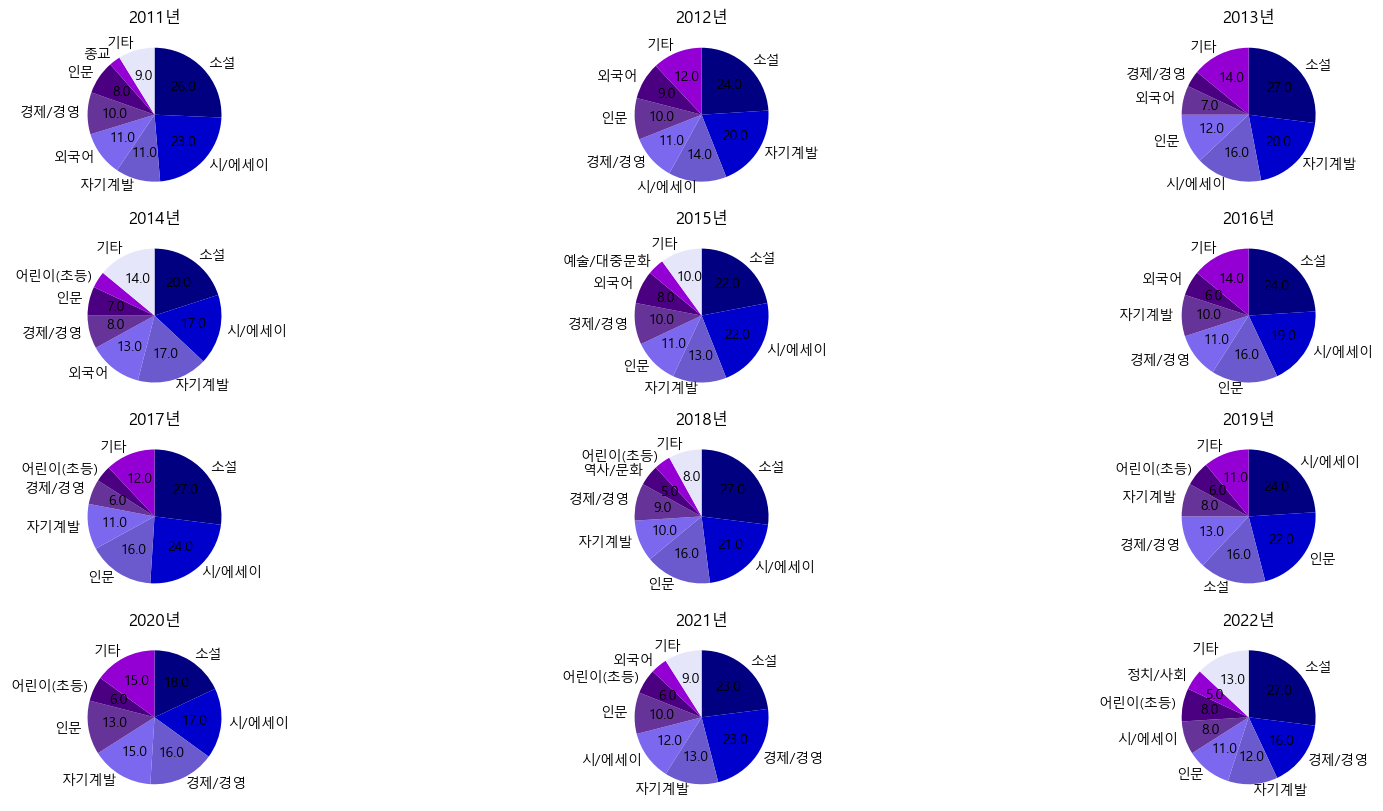

In [37]:
# 원그래프 연도별로 출력하기

plt.figure(figsize=(20,10))
colors = ['navy','mediumblue','slateblue','mediumslateblue','rebeccapurple','indigo','darkviolet','lavender']
# 2011년부터 2022년까지
years = [i for i in range(2011,2023)]
i = 1
for year in years:
    SQL = """with sub as (
        SELECT genre, count(*) c FROM best_books_12years
        WHERE years = {} GROUP BY genre ORDER BY 2 DESC)
    select * from  sub a where a.c > 3 
    union
    select concat('기타') genre, sum(b.c) c from sub b where b.c <= 3;""".format(year)
    cursor.execute(SQL)
    res = cursor.fetchall()
    dict_res = dict((x,y)for x,y in res) # # tuple -> dictionary
    
    ratio = []
    labels = []
    for key, value in dict_res.items():
        labels.append(key)
        ratio.append(value)
    plt.subplot(4,3,i)
    i+=1
    plt.pie(ratio, labels=labels, startangle=90, counterclock=False, autopct=(lambda x: str(round(x,0)) if x > 5 else ' '), colors=colors)
    plt.title('{}년'.format(year))
    
# 책이 3권 이하는 기타
plt.show()

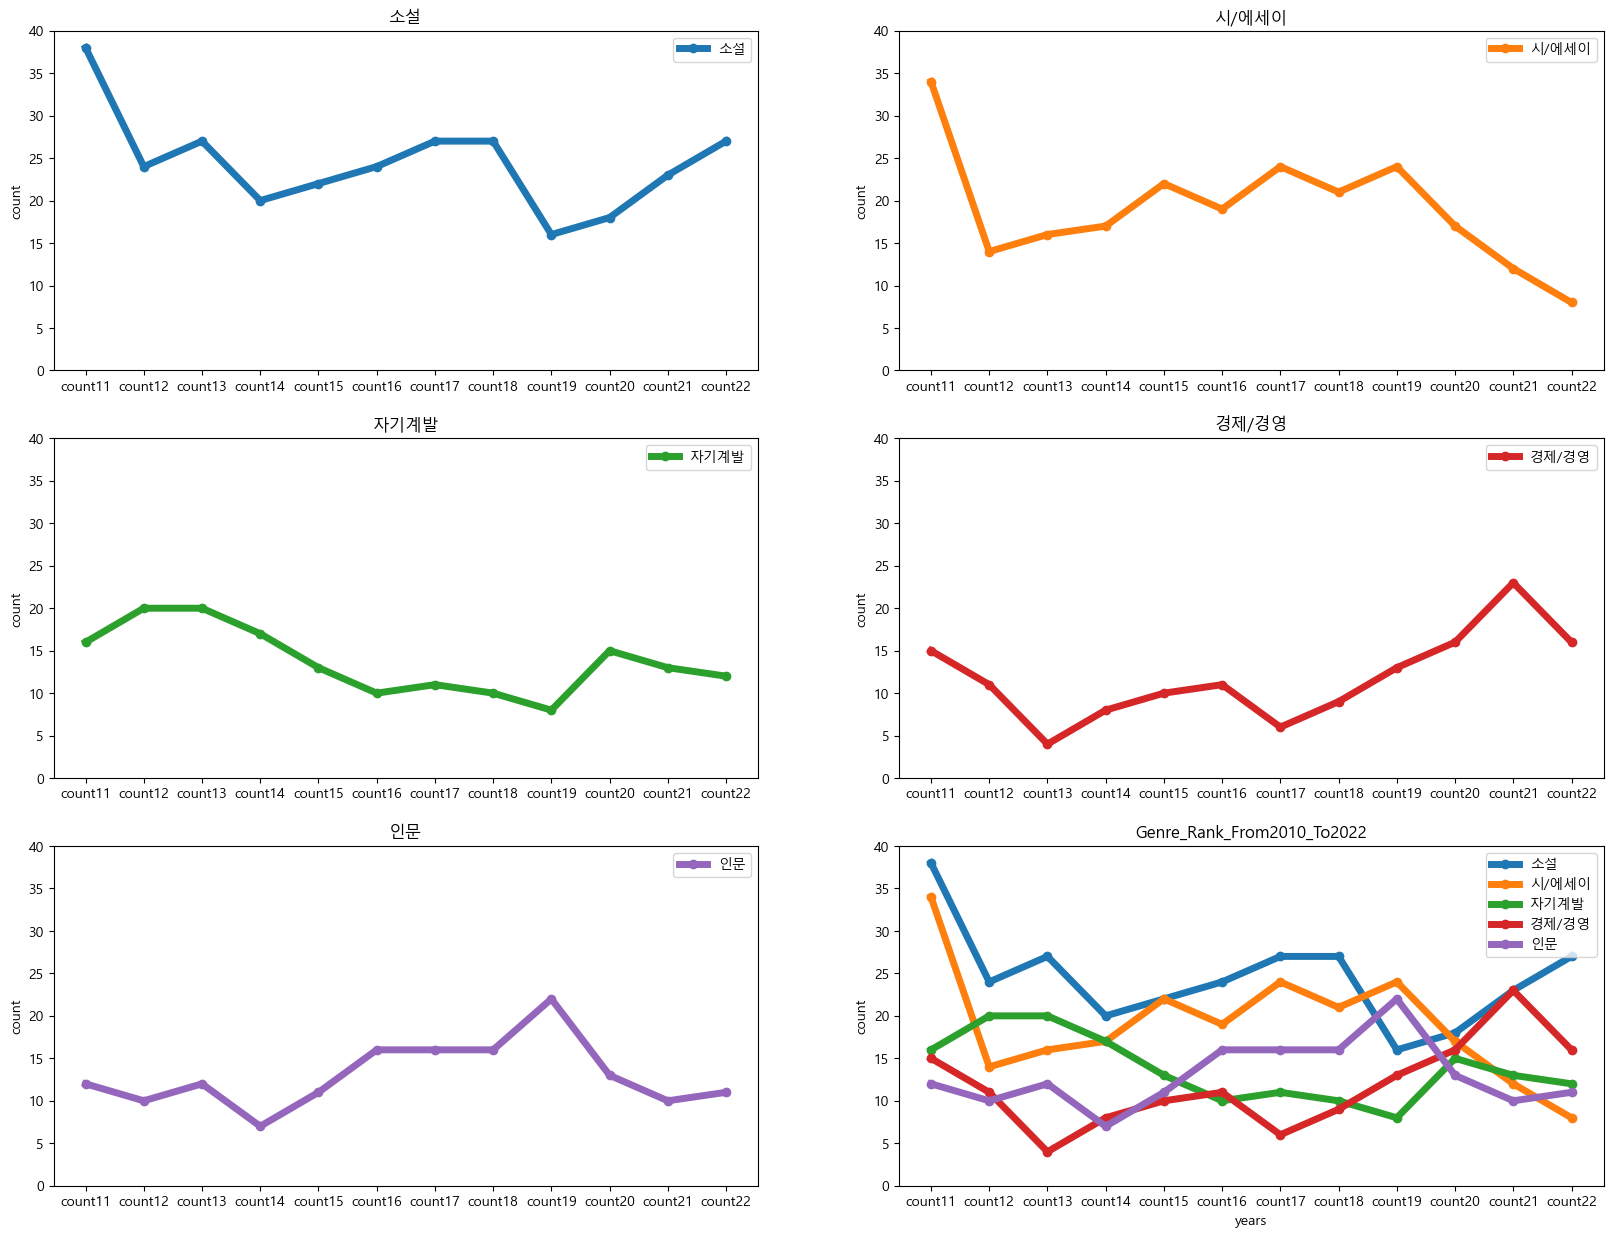

In [14]:
# '경제/경영','소설','시/에세이','인문','자기계발' 상위 5장르의 권 수 꺾은선 그래프

# 딕셔너리 형식으로 sql 분석쿼리 불러오기
cursor = db.cursor(pymysql.cursors.DictCursor) 
sql = """
WITH TOP5_genre AS(SELECT genre,count(*)
    FROM best_books_12years
    GROUP BY genre
    ORDER BY 2 DESC limit 5),    
book11 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2011 GROUP BY genre),
book12 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2012 GROUP BY genre),
book13 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2013 GROUP BY genre),
book14 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2014 GROUP BY genre),
book15 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2015 GROUP BY genre),
book16 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2016 GROUP BY genre),
book17 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2017 GROUP BY genre),
book18 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2018 GROUP BY genre),
book19 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2019 GROUP BY genre),
book20 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2020 GROUP BY genre),
book21 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2021 GROUP BY genre),
book22 AS(SELECT genre, count(*) c 
    FROM best_books_12years WHERE years=2022 GROUP BY genre)
SELECT g.genre, b11.c count11, b12.c count12, b13.c count13, b14.c count14, b15.c count15, 
        b16.c count16, b17.c count17, b18.c count18, b19.c count19, b20.c count20, b21.c count21, b22.c count22
FROM genre_idx g INNER JOIN TOP5_genre as t ON g.genre = t.genre
                 LEFT JOIN book22 b22 ON g.genre = b22.genre
                 LEFT JOIN book21 b21 ON g.genre = b21.genre
                 LEFT JOIN book20 b20 ON g.genre = b20.genre
                 LEFT JOIN book19 b19 ON g.genre = b19.genre
                 LEFT JOIN book18 b18 ON g.genre = b18.genre
                 LEFT JOIN book17 b17 ON g.genre = b17.genre
                 LEFT JOIN book16 b16 ON g.genre = b16.genre
                 LEFT JOIN book15 b15 ON g.genre = b15.genre
                 LEFT JOIN book14 b14 ON g.genre = b14.genre
                 LEFT JOIN book13 b13 ON g.genre = b13.genre
                 LEFT JOIN book12 b12 ON g.genre = b12.genre
                 LEFT JOIN book11 b11 ON g.genre = b11.genre
WHERE not(b22.c is null and b21.c is null and b20.c is null
      and b19.c is null and b18.c is null)
ORDER BY 2 DESC;"""
cursor.execute(query=sql)
result = cursor.fetchall()

fig = plt.figure(figsize=(20,15))
fig.set_facecolor('white')

# 각 장르별 경향
x = list(result[0].keys()); y = []
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
for i in range(len(result)):
    y.append(list(result[i].values()))
    plt.subplot(3,2,i+1)
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='5',color=colors[i])
    plt.title(y[-1][0])
    plt.legend(); plt.ylim([0,40])
    plt.ylabel('count')

# 종합
for i in range(len(result)):
    y.append(list(result[i].values()))
    plt.subplot(3,2,6)
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='5')
    plt.title('Genre_Rank_From2010_To2022')
    plt.xlabel('years'); plt.ylabel('count')

plt.legend()
plt.ylim([0,40])
plt.show()

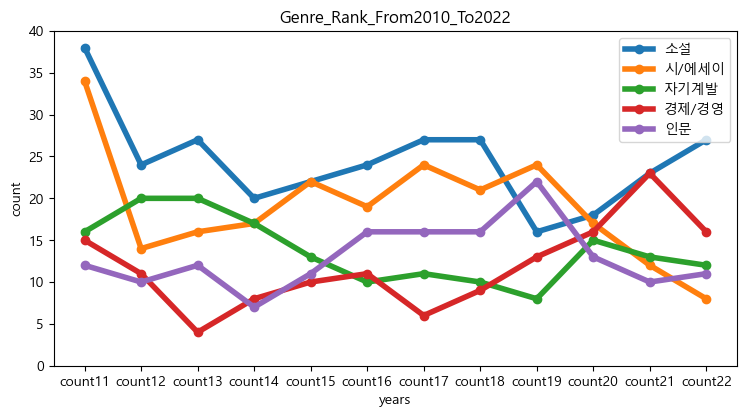

In [15]:
# 상위 5 장르 권 수 결과 확대
fig = plt.figure(figsize=(30,20))
fig.set_facecolor('white')
for i in range(len(result)):
    y.append(list(result[i].values()))
    plt.subplot(4,3,6)
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='4')

plt.title('Genre_Rank_From2010_To2022')
plt.xlabel('years'); plt.ylabel('count')
plt.legend()
plt.ylim([0,40])
plt.show()

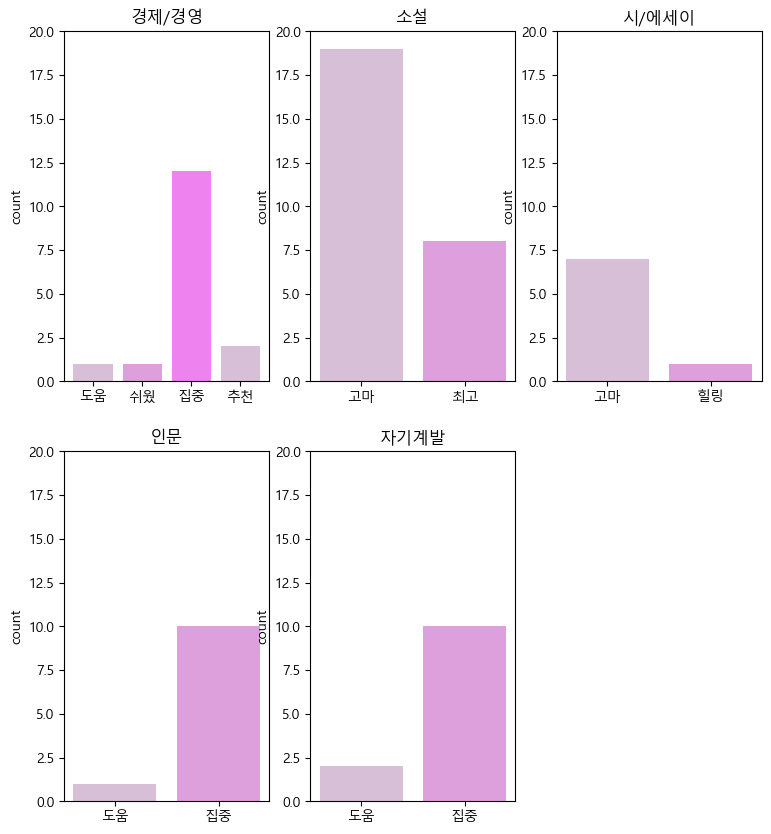

In [22]:
# 상위 5 장르 당 likes(코멘트) 경향성 막대그래프

sql = """SELECT genre, likes, count(likes) comment_n FROM best_books_12years
WHERE years = 2022 AND genre in ('소설','시/에세이','인문','자기계발','경제/경영')
GROUP BY genre, likes ORDER BY genre;"""

cursor.execute(query=sql)
result = cursor.fetchall() #result

genre_li = ['경제/경영','소설','시/에세이','인문','자기계발']
check = 0
data = [{},{},{},{},{}]
for i in range(len(result)):
    if result[i]['genre'] != genre_li[check]:
        check += 1
    data[check][result[i]['likes']] = result[i]['comment_n']

fig = plt.figure(figsize=(9,10))
for i in range(len(data)):
    plt.subplot(2,3,i+1)
    x = list(data[i].keys())
    values = list(data[i].values())
    plt.bar([x2[:2] for x2 in x], values, color=['thistle','plum','violet'])
    plt.title(genre_li[i])
    plt.ylim([0,20])
    plt.ylabel('count')
plt.show()

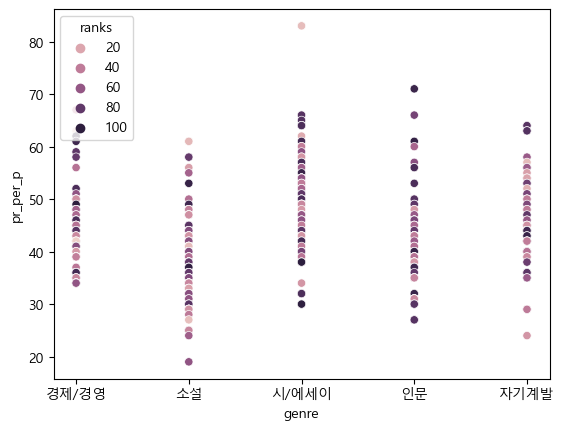

In [70]:
#sql문으로 테이블에 있는 정보 가져오기
db = pymysql.connect(host='localhost', port=3306, user='root', passwd='1234', db='mywork', charset='utf8')
cursor = db.cursor()
sql = """
WITH high_g AS(
    SELECT genre, count(*) g_c FROM best_books_5years
    GROUP BY genre HAVING count(*) >30 ORDER BY g_c DESC)
SELECT b.genre, a.pr_per_p, a.ranks
FROM g_pr_p_r a NATURAL JOIN high_g b ;"""
cursor.execute(sql)
test3= cursor.fetchall()

#판다스로 파이썬에서 테이블화 하기
pd.set_option('display.max_row', 700)
table3 = pd.DataFrame(test3, columns = ['genre', 'pr_per_p', 'ranks'])

#시각화 플랏 뽑기 _스캐터플랏
plot3 = sns.scatterplot(data=table3, x='genre', y = 'pr_per_p', hue='ranks')
plt.show()

In [ ]:
db.commit()
db.close